In [34]:
import pandas as pd
import xarray as xr
import numpy as np
import sys

sys.path.append('/home/users/jamd1/Isca/')
from isca_tools import cesm
from isca_tools.utils import area_weighting, lat_lon_rolling, print_ds_var_list, set_attrs
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.utils.moist_physics import moist_static_energy, sphum_sat
import isca_tools
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.patches as patches
from tqdm.notebook import tqdm
import matplotlib
from matplotlib.dates import ConciseDateConverter
matplotlib.units.registry[cftime.DatetimeNoLeap] = ConciseDateConverter()  # to allow plotting time as x axis
# plt.style.use('/home/users/jamd1/Isca/jobs/publish.mplstyle')
import os
# from geocat.comp.interpolation import interp_hybrid_to_pressure
print(os.getcwd())

/home/users/jamd1/Isca/jobs/cesm/pressure_levels


In [40]:
path_lcl_info = '/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/archive/test/pressure_levels/lcl_lev/'
ds = xr.open_mfdataset(f"{path_lcl_info}/*.nc")
ds = ds.load()

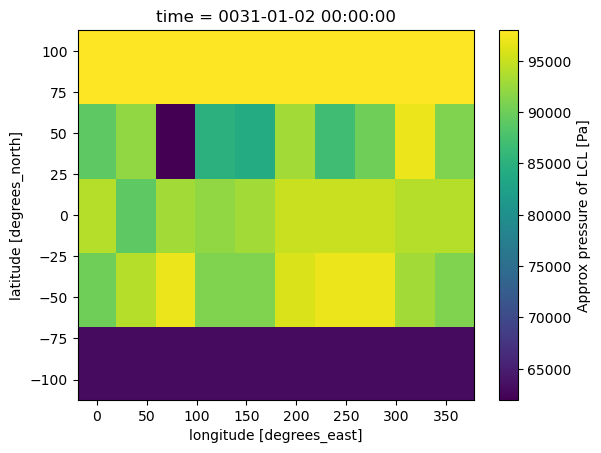

In [37]:
ds.p_at_lcl.isel(time=0).transpose().plot()

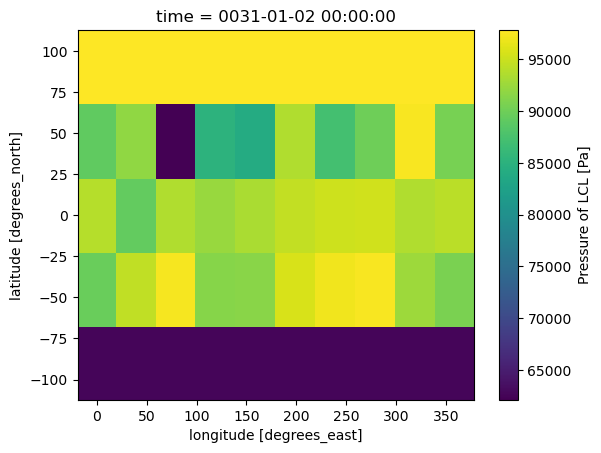

In [39]:
ds.p_lcl.isel(time=0).plot()

In [50]:
file_path = '/home/users/jamd1/Isca/jobs/cesm/theory_adiabat/temp_dist/6month_summer_lev/test/ocean/output.nd2'
ds = xr.load_dataset(file_path)
ds = ds.load()

In [75]:
ds2 = xr.open_dataset('/gws/nopw/j04/global_ex/jamd1/cesm/CESM2.1.3/archive/e.e20.E1850TEST.f09_g17.daily_output/pressure_levels/lcl_lev/0035.nc',
                decode_times=False).load()

In [76]:
ds2

<xarray.Dataset> Size: 484MB
Dimensions:    (time: 365, lat: 192, lon: 288)
Coordinates:
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 3kB 1.241e+04 1.241e+04 ... 1.277e+04 1.278e+04
Data variables:
    p_lcl      (time, lat, lon) float32 81MB 6.172e+04 6.172e+04 ... 9.641e+04
    T_lcl      (time, lat, lon) float32 81MB 244.0 244.0 244.0 ... 247.2 247.2
    Z3_lcl     (time, lat, lon) float32 81MB 3.623e+03 3.623e+03 ... 357.6 357.6
    p_at_lcl   (lon, lat, time) float32 81MB 6.2e+04 6.5e+04 ... 9.2e+04 9.6e+04
    T_at_lcl   (time, lon, lat) float32 81MB 246.8 248.2 248.6 ... 247.6 248.8
    Z3_at_lcl  (time, lon, lat) float32 81MB 3.594e+03 3.48e+03 ... 377.3 389.3

In [2]:
cesm.get_exp_file_dates('test', hist_file=1)

<xarray.DataArray 'time' (time: 3)> Size: 24B
array(['0041-01-02T00:00:00', '0042-01-02T00:00:00',
       '0043-01-02T00:00:00'], dtype='datetime64[s]')
Dimensions without coordinates: time

In [ ]:
var_atm = ['T', 'Q', 'Z3', 'PS', 'P0', 'hyam', 'hybm', 'gw']
ds = cesm.load_dataset('test', hist_file=1, month_files=None, year_files='first10')[var_atm]


In [ ]:
ds.time

In [ ]:
# Remove time dependence of variables constant in time
p_ref = ds.P0.isel(time=0)
hyam = ds.hyam.isel(time=0)
hybm = ds.hybm.isel(time=0)

In [ ]:
interp_hybrid_to_pressure(ds.Z3, ds.PS, hyam, hybm, p_ref, np.asarray([800*100]), extrapolate=True, variable='other').isel(time=0, plev=0).plot()

In [ ]:
interp_hybrid_to_pressure(ds.Z3, ds.PS, hyam, hybm, p_ref, np.asarray([800*100])).isel(time=0, plev=0).plot()

In [ ]:
exp = 'e.e20.E1850TEST.f09_g17'
ds_ref = cesm.load_dataset(f'{exp}.co2_2x_daily_output', hist_file=1, year_files=32)[['P0', 'hyam', 'hybm']]
ds_ref = ds_ref.isel(time=0).load()
ds_full = cesm.load_dataset(f'{exp}.co2_2x_daily_output', hist_file=1, year_files=32)[['PS', 'T', 'Z3']]

In [ ]:
%%time
ds_full.load()

In [ ]:
t500 = interp_hybrid_to_pressure(ds_full.T, ds_full.PS, ds_ref.hyam, ds_ref.hybm, ds_ref.P0, np.asarray([500*100]))
z500 = interp_hybrid_to_pressure(ds_full.T, ds_full.PS, ds_ref.hyam, ds_ref.hybm, ds_ref.P0, np.asarray([500*100]))

In [ ]:
ds_out = xr.Dataset({'Z3': z500, 'T': t500})
set_attrs(ds_out.plev, long_name='pressure', units='Pa')

In [ ]:
encoding = {var: {'zlib': True, 'complevel': 4} for var in ds_out.data_vars}
out_path = '/gws/nopw/j04/global_ex/jamd1/cesm/test.nc'
# ds_out.to_netcdf(out_path, encoding=encoding)